In [1]:
from enyo.etc.snr import SNRSpectrum
from enyo.etc import source, efficiency, telescopes, spectrum, extract, aperture
from matplotlib import pyplot
import numpy
import astropy.constants
from astropy.modeling import models, fitting
import os

In [2]:
# Set the object spectrum based on some emission lines
wave = numpy.power(10., numpy.arange(15000)*5e-5 + numpy.log10(3100))
redshift = 2.0

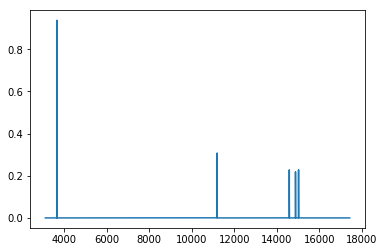

In [3]:
# Get source spectrum; for now assumed to be the same for all parts of the object.
spectrum_type = 'emline'
if spectrum_type == 'constant':
    source_spectrum = spectrum.Spectrum(wave, numpy.ones_like(wave, dtype=float), log=True)
elif spectrum_type == 'blue':
    source_spectrum = spectrum.BlueGalaxySpectrum(redshift=redshift)
elif spectrum_type == 'emline':
    # Flux in 1e-17 erg/s/cm^2
    flux = numpy.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    # Line names
    names = numpy.array(['Lya', '[OII]3727', '[OII]3729', 'Hb', '[OIII]4960', '[OIII]5008'])
    # Wavelength in angstroms
    restwave = numpy.array([ 1216., 3727.092, 3729.875, 4862.691, 4960.295, 5008.240])
    # Line FWHM in km/s
    fwhm = numpy.array([50., 50., 50., 50., 50., 50.])
    # Source spectrum in 1e-17 erg/s/cm^2/angstrom
    source_spectrum = spectrum.EmissionLineSpectrum(wave, flux, restwave, fwhm, units='km/s',
                                                    redshift=redshift,
                                                    resolution=5000, log=True)
source_spectrum.show()

In [4]:
# Build the source surface brightness distribution
reff = 2.0
sersic_n = 1.0
ellipticity = 0.4
position_angle = 45
intrinsic = None          # If None, assumed to be point source
if reff is not None and sersic_n is not None:
    intrinsic = source.OnSkySersic(1.0, reff, sersic_n, ellipticity=ellipticity,
                                   position_angle=position_angle)
    
# Construct the on-sky source distribution
seeing = 0.8
onsky = source.OnSkySource(seeing, intrinsic, sampling=0.05, size=10)

In [5]:
print(onsky.size, onsky.sampling)
print(onsky.seeing.size, onsky.seeing.sampling)
print(onsky.intrinsic.size, onsky.intrinsic.sampling)

10 0.05
10 0.05
10 0.05


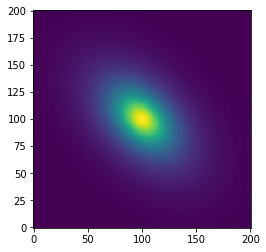

In [6]:
pyplot.imshow(onsky.data, origin='lower', interpolation='nearest')

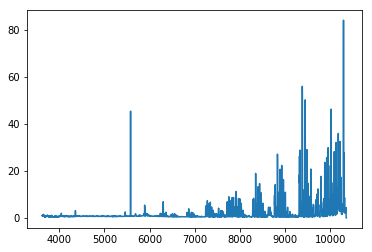

In [7]:
# Get the sky spectrum
sky_spectrum = spectrum.MaunakeaSkySpectrum()
sky_spectrum.show()

In [8]:
airmass = 1.0
atmospheric_throughput = efficiency.AtmosphericThroughput(airmass=airmass)

In [9]:
# Telescope; mostly just used for aperture area
telescope = telescopes.KeckTelescope()

In [19]:
# Define the observing aperture; fiber diameter is in arcseconds
fiber_diameter = 1.0
fiber = aperture.FiberAperture(0, 0, fiber_diameter, resolution=100)
print(fiber.area)
print(numpy.pi*(fiber_diameter/2)**2)


0.7853658655910346
0.7853981633974483


In [20]:
aperture_image = fiber.grid_overlap(onsky.x, onsky.y, method='fractional')
print(numpy.sum(aperture_image))

0.7853658655910276


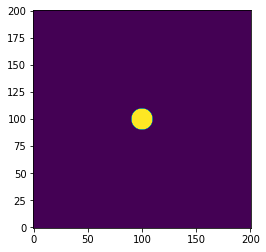

In [21]:
pyplot.imshow(aperture_image, origin='lower', interpolation='nearest')

In [22]:
# Get the full system (top of telescope) throughput

# Spectrograph throughput
throughput_curve = 'wfos'
if throughput_curve == 'wfos':
    data_file = os.path.join(os.environ['ENYO_DIR'], 'data/efficiency', 'fiber_wfos_throughput.db')
    db = numpy.genfromtxt(data_file)
    spectrograph_throughput = efficiency.SpectrographThroughput(db[:,0], total=db[:,3])
elif throughput_curve == 'desi':
    data_file = os.path.join(os.environ['ENYO_DIR'], 'data/efficiency', 'desi_spectrograph_thru.txt')
    db = numpy.genfromtxt(data_file)
    spectrograph_throughput = efficiency.SpectrographThroughput(db[:,0], total=db[:,1])
else:
    raise NotImplementedError('Spectrograph unknown: {0}'.format(throughput_curve))

# Coating efficiency
coating_efficiency = efficiency.Efficiency.from_file(os.path.join(os.environ['ENYO_DIR'], 'data/efficiency',
                                                                  'aluminum.db'))

# System efficiency including 3 aluminum bounces
system_throughput = efficiency.SystemThroughput(source_spectrum.wave, spectrograph=spectrograph_throughput,
                                                surfaces=3, coating=coating_efficiency)

In [ ]:
# Aperture Efficiency
fiber_diameter = 1.0
aperture_efficiency = efficiency.ApertureEfficiency(source_spectrum.wave, fiber_diameter, source=source,
                                                    seeing=seeing)

In [ ]:
exposure_time = 3600
seeing = 0.8
resolution = 5000
snr_spectrum = SNRSpectrum(source, source_spectrum, telescope, system_throughput, atmospheric_throughput,
                           exposure_time, seeing, resolution)

In [ ]:
s = SNRSpectrum(20., 1.0, 0.8, 1.0, 5000, 1., 0., 0.9)

In [ ]:
pyplot.plot(s.coating_efficiency.wave, s.coating_efficiency.eta)

In [ ]:
pyplot.plot(s.system_throughput.wave, s.system_throughput.eta)

In [ ]:
pyplot.plot(s.atmospheric_extinction.wave, s.atmospheric_extinction.eta)

In [ ]:
pyplot.plot(s.source_spectrum.wave, s.snr)

In [ ]:
s.source_spectrum.photon_flux()

In [ ]:
s.source_spectrum.flux

In [ ]:
# Fit the data using a Gaussian
fit_g = fitting.LevMarLSQFitter()
fit = numpy.zeros_like(emlspectrum.flux)
for c in restwave:
    g_init = models.Gaussian1D(amplitude=0.1, mean=c*(1+redshift), stddev=1.)
    g = fit_g(g_init, emlspectrum.wave, emlspectrum.flux)
    fit += g(emlspectrum.wave)
    print('{0:.1f} {1:.1f} {2:.1f} {3:.1f}'.format(numpy.sum(numpy.diff(emlspectrum.wave)*g(emlspectrum.wave[1:])),
                                                   c*(1+redshift), g.mean.value,
                    astropy.constants.c.to('km/s').value*g.stddev.value/g.mean.value*numpy.sqrt(8*numpy.log(2))))
pyplot.plot(emlspectrum.wave, emlspectrum.flux)
pyplot.plot(emlspectrum.wave, fit)
pyplot.xlim([11100,11300])